### Setup for colab

In [ ]:
# For colab only
!pip install git+https://github.com/Hollfelder-Lab/lrDMS-IRED.git

### General setup


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotstyle.export import save_timestamped_figure
from plotstyle.colors import cambridge_core
from plotstyle.size import get_dim, WIDTH

from lrdms.constants import DATA_PATH

SAVE = True
SAVE_DIR = "./figures/double_mutant_model"

In [10]:
# General imports for all experiments
from lrdms.data.srired import IRED
from lrdms.utils.mutations import Variant
from lrdms.data.predictions import VariantPredictions
from loguru import logger

# Prepare double mutant model features

1. Load experimental data

In [11]:
srired = IRED()

2024-05-29 02:07:46.411 | INFO     | lrdms.data.srired:_process_raw_data:44 - Remove 0 NaN sequences
2024-05-29 02:07:46.415 | INFO     | lrdms.data.srired:_process_raw_data:48 - Remove 0 NaN fitness values
2024-05-29 02:07:46.424 | INFO     | lrdms.data.srired:_process_raw_data:53 - Remove 1320 sequences not ending in stop
2024-05-29 02:07:46.437 | INFO     | lrdms.data.srired:_process_raw_data:59 - Remove 981 sequences with intermediate stop
2024-05-29 02:07:46.459 | INFO     | lrdms.data.srired:_process_raw_data:70 - Remove 0 sequences with non-standard AAs
2024-05-29 02:07:46.468 | INFO     | lrdms.data.srired:_process_raw_data:75 - Remove 15 sequences with length != 290
2024-05-29 02:07:46.479 | INFO     | lrdms.data.srired:_process_raw_data:81 - Remove 3 sequences with >15 mutations
2024-05-29 02:07:46.485 | INFO     | lrdms.data.srired:_process_raw_data:93 - Parsing variants from sequences
2024-05-29 02:07:46.659 | INFO     | lrdms.data.srired:_process_raw_data:98 - Evaluating r

2. Load variants from dataframes that store the pre-computed features based on the 3D structure & sequence

Load processed single, double and higher order mutants (pre-computed for convenience, as computing ESM language model features can takes several hours and requires a GPU. While we later learn from ablations that these features are not crucial, we keep them here to reproduce the paper's results)

In [12]:
save_dir = DATA_PATH / "processed"
# Load variants with pre-computed features based on the 3D structure & sequence
singles = VariantPredictions.from_df(srired, pd.read_csv(save_dir / "singles_processed.csv", index_col=0))
doubles = VariantPredictions.from_df(srired, pd.read_csv(save_dir / "doubles_processed.csv", index_col=0))
higher = VariantPredictions.from_df(srired, pd.read_csv(save_dir / "higher_processed.csv", index_col=0))

# Turn variants into objects
for variants in [singles, doubles, higher]:
    variants.data.variant = variants.data.variant.apply(Variant.from_str)

3. Add single mutation features (structural features at the positions, single mutant ESM predictions & fitnesses) to double mutations 

In [13]:
# Add single mutation features to doubles
def _get_single_mut_features(mutant, single_features="all"):
    df = singles.data.drop(columns=["observed", "hamming_to_wildtype"]).set_index("variant")
    if single_features == "all":
        single_features = df.columns

    return df.loc[mutant, single_features]


def add_single_features(X, single_features="all"):
    n_mut = len(X.variant.iloc[0])

    original_df = [X.reset_index(drop=True)]
    mutant_feature_dfs = [
        _get_single_mut_features(X.variant.apply(lambda x: x.mutations[i]), single_features=single_features)
        .reset_index(drop=True)
        .add_suffix(f"_{i+1}")
        for i in range(n_mut)
    ]

    return pd.concat(original_df + mutant_feature_dfs, axis=1, ignore_index=False)


doubles.data = add_single_features(doubles.data)

# Replication of model used for predicting variants for wet-lab validation

In [14]:
from lrdms.model.double_mutations import CombinabilityModel
import xgboost as xgb
import re

THRESHOLD = 0.0
LOW_FITNESS_CUTOFF = -5.0
FEATURES = [
    "true_fitness_min",
    "combinability_pos",
    "combinability_neg",
    "additive_fitness",
    "esm_fitness",
    "nma_msqf_min",
    "nma_msqf_max",
    "ca_ligand_dist_min",
    "catalytic_dist_min",
    "interface_dist_min",
    "esm_epi",
]
TARGET = "true_fitness"
DATA_BALANCE_WEIGHTS = "reproduce_paper"  #  "reproduce_paper" or "use_full_data"

/Users/simon/code/lrDMS-IRED/src/lrdms/features/dms.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Replicate the training and predictiosn of the double-mutant model that was used in the paper.

In [15]:
# Full run with all data
# ... data selection
X_all = doubles.data.query("observed & (true_fitness > -inf)")
y_all = X_all.true_fitness
combinability_all = pd.concat([doubles.data.query("observed"), higher.data])[["variant", "true_fitness"]]
combinability_all["hamming_to_wildtype"] = combinability_all.variant.apply(len)
# ... compute weights to balance data (negative examples are much more common than positive double mutants)
# NOTE: The weights were calibrated on an 80% train-test split of the data, during cross validation and
#  hyperparameter tuning. For full data training for the final predictions, we could have re-computed
#  slightly more accurate weights using the full data, but we forgot to do so for the final model
#  we used in our wet-lab validation. We re-compute the 80% data based sample weights here for reproducibility
#  of the final model in the paper, but note that when re-weighting with weights based on 100% of the data
#  predictiosn further improve the final model performance (various double mutants at positiosn 203 & 241, the
#  location of our best mutant, are ranked among the top 5).
if DATA_BALANCE_WEIGHTS == "reproduce_paper":
    train_ids = set(doubles.data.query("observed").sample(frac=0.8, random_state=42).variant.values)
    test_ids = set(doubles.data.query("observed").variant.values) - train_ids
    train_data = doubles.data.query("(variant in @train_ids) & (true_fitness > -inf)").copy()
    train_data["potentially_useful"] = train_data.true_fitness > THRESHOLD
    true_count = train_data.potentially_useful.sum()
    false_count = (~train_data.potentially_useful).sum()
    pos_to_neg_ratio = true_count / false_count  # == 0.215
    print(f"True count: {true_count}, False count: {false_count}, Ratio: {pos_to_neg_ratio}")
elif DATA_BALANCE_WEIGHTS == "use_full_data":
    true_count = doubles.data.query(f"observed & true_fitness > {THRESHOLD}").observed.count()
    false_count = doubles.data.query(f"observed & true_fitness < {THRESHOLD}").observed.count()
    pos_to_neg_ratio = true_count / false_count  # == 0.141
    print(f"True count: {true_count}, False count: {false_count}, Ratio: {pos_to_neg_ratio}")
weights = np.where(y_all > 0, 1.0 / true_count, 1.0 / false_count)
weights /= weights.mean()

# Model set up
# ... set up xgboost base model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # rank:pairwise
    # objective="rank:pairwise",
    booster="gbtree",
    random_state=42,
    seed=42,
    # scale_pos_weight= false_count / true_count # == 4.630490956072351,  # NOTE: Treated by sample weights (below) directly
    gamma=0.5,
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    # eta=0.1,
)
# ... wrap into CombinabilityModel
model = CombinabilityModel(
    model=xgb_model, wt_seq_len=srired.sequence_length, features_to_use=FEATURES, aggr_funcs=[np.mean, np.min, np.max]
)

# Fit model
model.fit(X_all, y_all.clip(LOW_FITNESS_CUTOFF), combinability_all, sample_weight=weights)

# Predict on all double mutants in `trust region` (i.e. doubles that can be constructed from observed singles)
X_pred = doubles.data.query("~observed")
predictions = model.prepare_features(X_pred)
predictions["variant"] = X_pred["variant"]
predictions["predicted_fitness"] = model.predict(X_pred)

# Log top 100 suggestions (the top 5 were sent to the wet-lab)
best_suggestions = predictions.sort_values(["predicted_fitness"], ascending=False).head(20)
best_suggestions[["variant", "predicted_fitness", *FEATURES]]

True count: 387, False count: 1792, Ratio: 0.21595982142857142


,variant,predicted_fitness,true_fitness_min,combinability_pos,combinability_neg,additive_fitness,esm_fitness,nma_msqf_min,nma_msqf_max,ca_ligand_dist_min,catalytic_dist_min,interface_dist_min,esm_epi
157036,"S35T,S51G",2.111187,-0.189081,51,264,-0.325901,2.831058,0.182866,0.187677,3.744922,19.871347,17.774124,0.061410
657836,"P203Q,T241A",1.918021,0.067833,51,203,1.901299,-4.816442,0.066425,0.088031,4.806287,6.800161,6.800161,0.009434
657843,"P203L,T241A",1.884657,0.293004,51,203,2.126469,-5.951675,0.066425,0.088031,4.806287,6.800161,6.800161,0.017691
657837,"P203Q,T241P",1.881294,0.067833,51,203,1.203343,-9.716291,0.066425,0.088031,4.806287,6.800161,6.800161,0.071385
160174,"S35T,T241A",1.861357,-0.189081,48,175,1.644384,2.694601,0.066425,0.187677,3.744922,6.800161,6.800161,0.004707
657821,"P203A,T241K",1.849089,0.227484,51,203,3.169854,-12.372214,0.066425,0.088031,4.806287,6.800161,6.800161,-0.009001
657846,"P203L,T241S",1.831569,0.293004,51,203,0.982001,-7.716222,0.066425,0.088031,4.806287,6.800161,6.800161,-0.031331
190570,"Q41P,T241S",1.829757,0.340881,43,174,1.029879,4.062568,0.066425,0.187677,4.806287,6.800161,6.800161,0.009115
190567,"Q41P,T241A",1.829757,0.340881,43,174,2.174347,5.789338,0.066425,0.187677,4.806287,6.800161,6.800161,0.020360
657830,"P203S,T241P",1.811662,0.678298,51,203,1.813807,-9.145430,0.066425,0.088031,4.806287,6.800161,6.800161,0.097424


# Shap value explanations

Convenience functions to beautify plots

In [16]:
from plotstyle.patch import patch_plot


def _apply_plotstyle(style="nature", figsize=WIDTH.nature_column):
    # adapt plot style and fig size
    fig, ax = patch_plot(style=style, figsize=figsize)

    # get y-label of current axis
    y_tick_labels = [item.get_text() for item in ax.get_yticklabels()]
    # set list of strings as labels
    ax.set_yticklabels(
        [
            label.replace("_", " ")
            .capitalize()
            .replace("Esm", "ESM")
            .replace("Nma", "NMA")
            .replace("esm", "ESM")
            .replace("nma", "NMA")
            for label in y_tick_labels
        ]
    )

    return fig, ax


def _save_shap_for_publication(name, save=SAVE, save_dir=SAVE_DIR):
    _apply_plotstyle("nature", WIDTH.nature_2column)
    if save:
        save_timestamped_figure(name + "_2col", save_dir=SAVE_DIR, file_types=["pdf"], date_format="")
    plt.show()

Shapley values analysis to better understand feature contributions

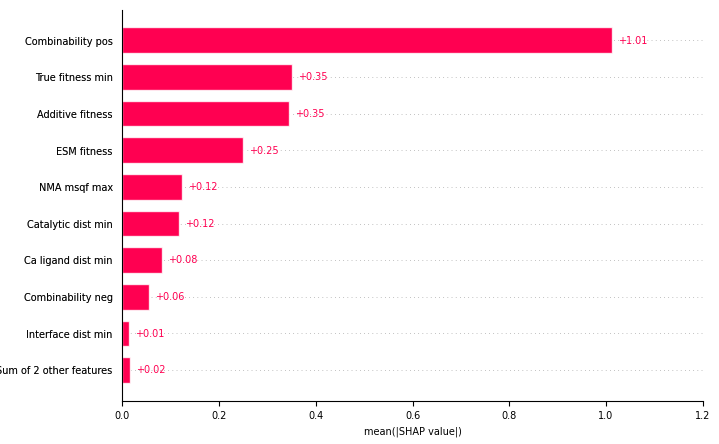

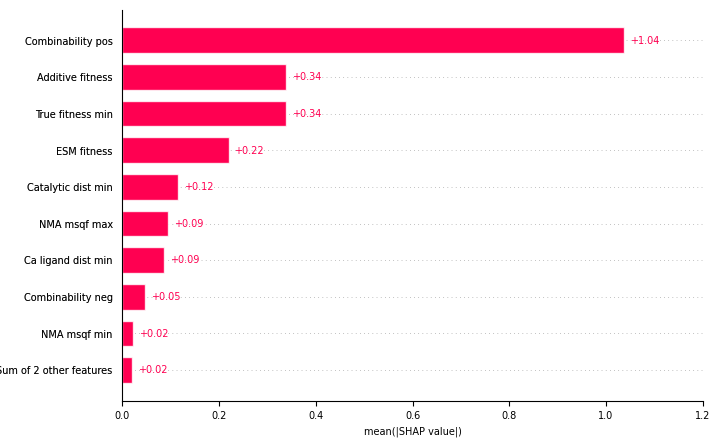

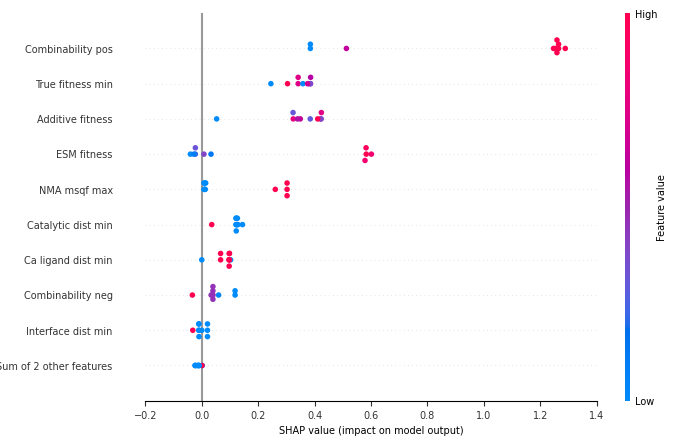

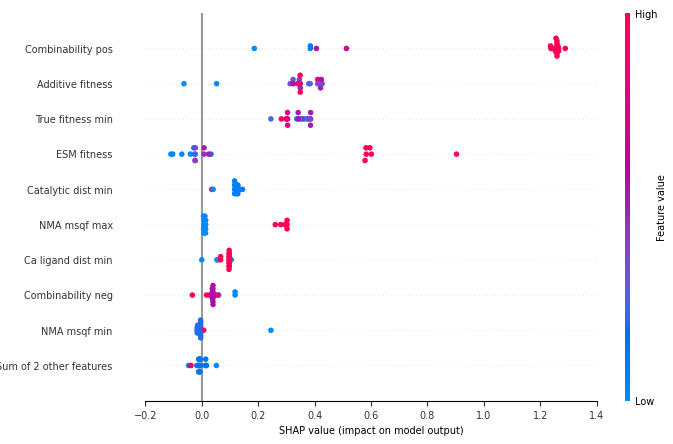

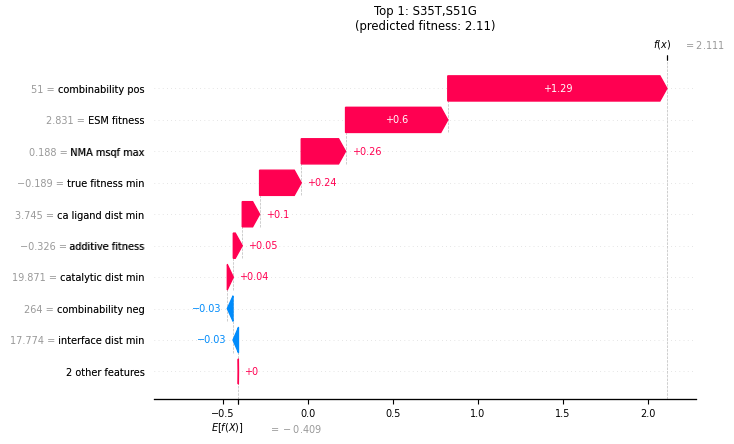

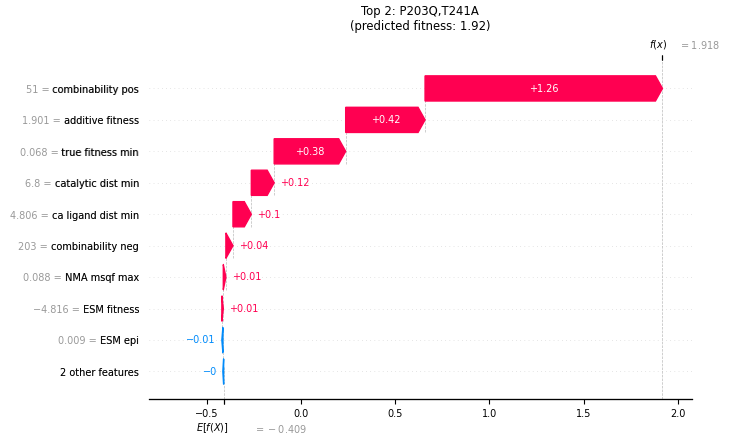

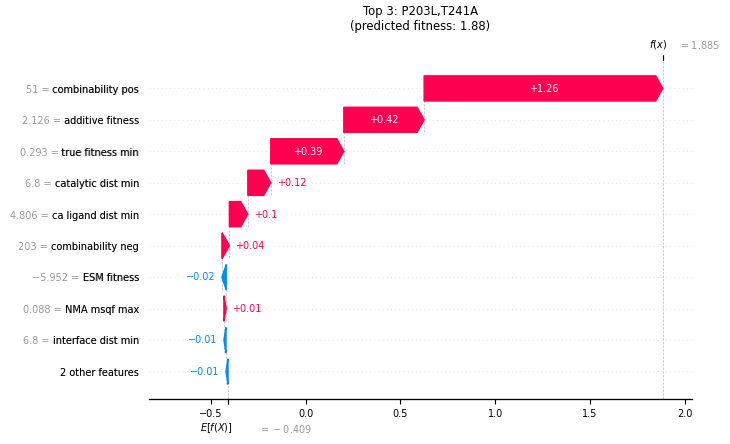

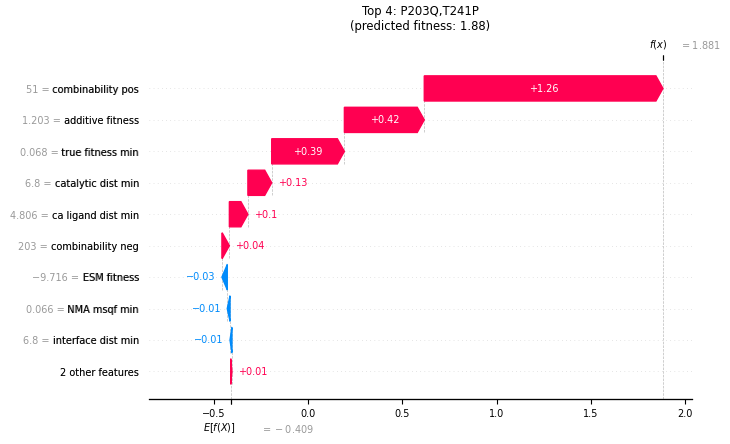

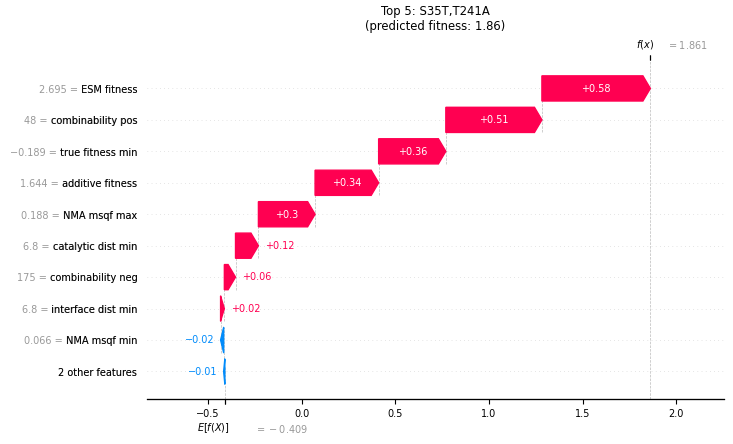

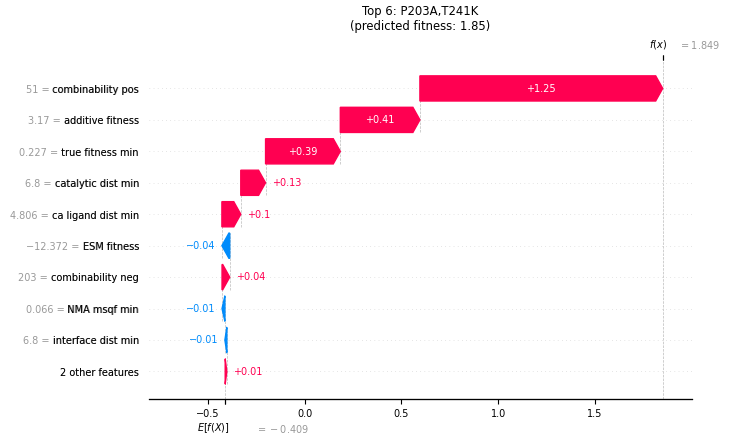

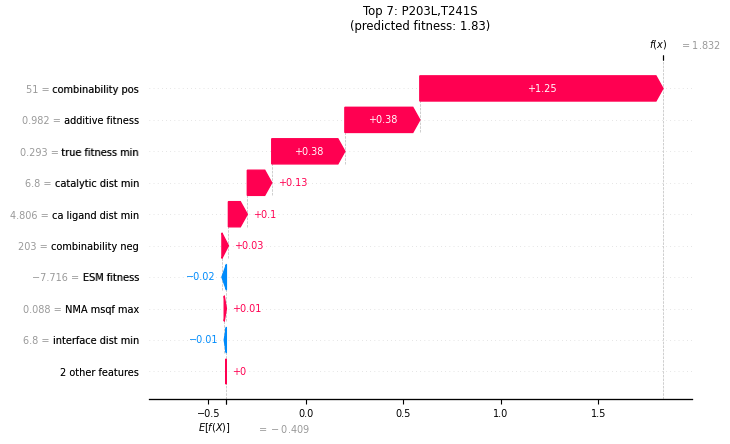

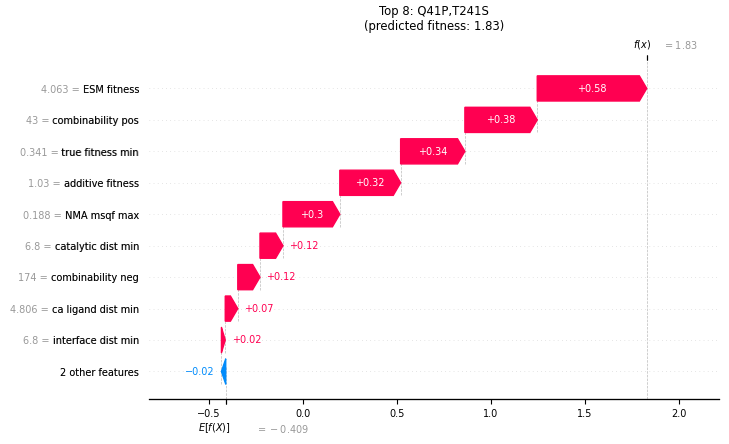

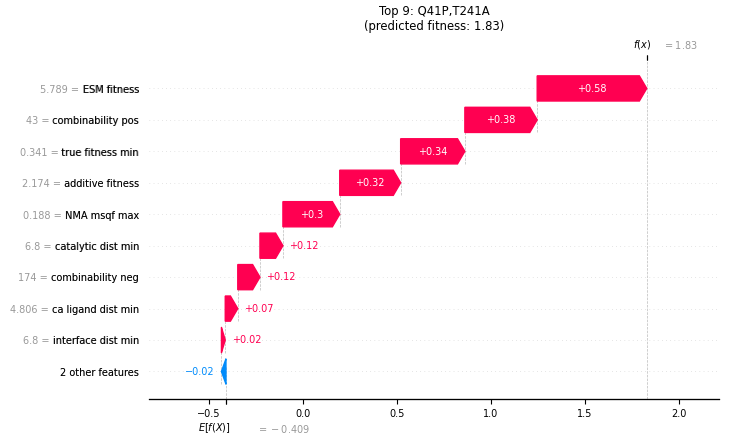

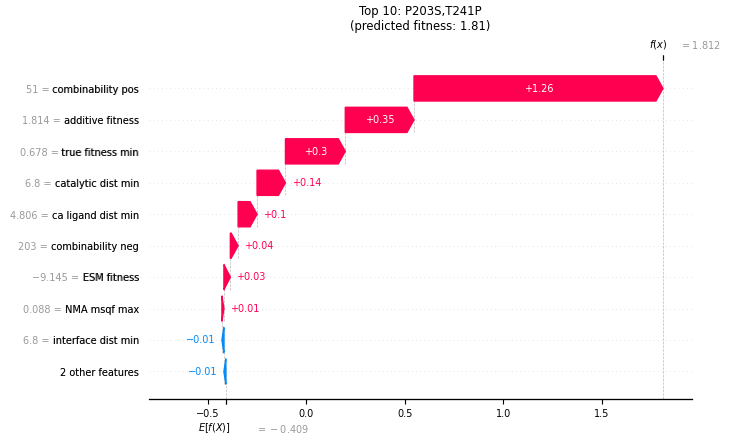

In [17]:
import shap

feature_names = [f.replace("_", " ").capitalize().replace("Esm", "ESM").replace("Nma", "NMA") for f in FEATURES]
explainer = shap.TreeExplainer(model.model, feature_names=feature_names)
shap_values = explainer(best_suggestions[FEATURES])

shap.plots.bar(shap_values[:10], max_display=10, show=False)
_save_shap_for_publication("feature_importance_shap_bar_top10", save=SAVE)

shap.plots.bar(shap_values, max_display=10, show=False)
_save_shap_for_publication("feature_importance_shap_bar_top100", save=SAVE)

shap.plots.beeswarm(shap_values[:10], show=False)
_save_shap_for_publication("feature_importance_shap_beeswarm_top10", save=SAVE)

shap.plots.beeswarm(shap_values, show=False)
_save_shap_for_publication("feature_importance_shap_beeswarm_top100", save=SAVE)

# And for individual variants
for i in range(10):
    shap.plots.waterfall(shap_values[i], max_display=10, show=False)
    plt.title(
        f"Top {i+1}: {best_suggestions.variant.iloc[i]}\n(predicted fitness: {best_suggestions.predicted_fitness.iloc[i]:.2f})"
    )
    _save_shap_for_publication(f"feature_importance_shap_waterfall_top{i+1}", save=SAVE)

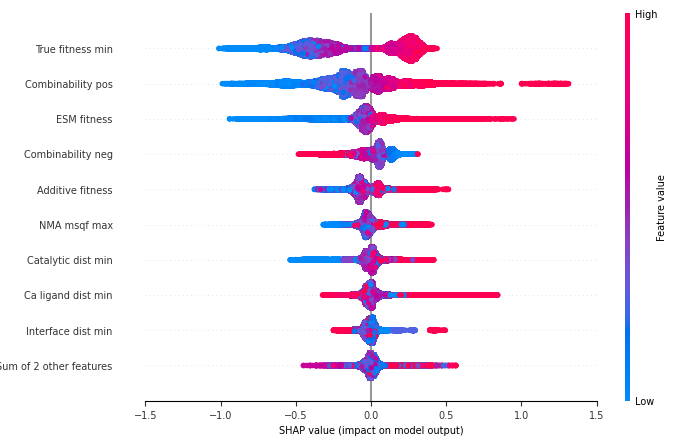

In [18]:
shap_values_all = explainer(predictions[FEATURES])
shap.plots.beeswarm(shap_values_all, show=False)
_save_shap_for_publication("feature_importance_shap_beeswarm_all_doubles", save=SAVE)

# Learning curves

In [19]:
from lrdms.utils.common import named_partial
from lrdms.eval.metrics import ndcg_at_k, precision_at_k, spearman, topk_mean, hit_rate
from lrdms.eval.learning_curves import (
    WELL_PLATE_SIZES,
    compute_learning_curves,
    compute_learning_curves_with_combinability,
)
from sklearn.model_selection import RepeatedKFold
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Well plate sizes
WELL_PLATE_SIZES_TICKS = [12, 24, 48, 96, 2 * 96, 384, 2 * 384, 1536, 2 * 1536]

# Set up metrics
METRICS = [
    spearman,
    named_partial(ndcg_at_k, k=10, name="top10_ndcg"),
    named_partial(ndcg_at_k, k=100, name="top100_ndcg"),
    named_partial(precision_at_k, k=10, name="top10_precision"),
    named_partial(topk_mean, topk=10, name="top10_mean"),
    named_partial(hit_rate, topk=10, name="top10_hit_rate"),
]

# Set up consistent cross validation for all ablations
CV = RepeatedKFold(n_splits=5, n_repeats=6, random_state=7)

ESM baseline:

In [20]:
from lrdms.model.single_mutations import LookUpPredictor

# ESM performance (including batch effects)
doubles_for_esm = doubles.data.query("observed").copy()
doubles_for_esm["seq"] = doubles_for_esm.variant.apply(lambda x: x.get_sequence(srired.wildtype_seq))

esm_performances = compute_learning_curves(
    X=doubles_for_esm.seq.values,
    y=doubles_for_esm.true_fitness.values.clip(LOW_FITNESS_CUTOFF),
    model=LookUpPredictor(doubles_for_esm.set_index("seq")["esm_fitness"].to_dict(), reg_coef=1e-6),
    sizes=WELL_PLATE_SIZES[:1],
    metrics=METRICS,
    store_predictions=False,
    cv=CV,
    random_state=7,
    shuffle_data=True,
)

# ESM zero-shot performance (excluding batch effects)
ESM_ZERO_SHOT = {
    name: metric(
        y_true=doubles.data.query("observed")["true_fitness"].values,
        y_pred=doubles.data.query("observed")["esm_fitness"].values,
    )
    for name, metric in zip([m.__name__ for m in METRICS], METRICS)
}

/opt/homebrew/Caskroom/miniconda/base/envs/lrdms/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [21]:
output = compute_learning_curves_with_combinability(
    X=doubles.data.query("observed"),
    y=doubles.data.query("observed").true_fitness.clip(LOW_FITNESS_CUTOFF),
    combinability_all=combinability_all,
    model=model,
    cv=CV,
    random_state=7,
    metrics=METRICS,
)

2024-05-29 02:10:26.600 | WARNING  | lrdms.eval.learning_curves:compute_learning_curves_with_combinability:148 - Dropping sizes > 3121 (smallest cross-validation subset size)


In [22]:
esm_ablation = compute_learning_curves_with_combinability(
    X=doubles.data.query("observed"),
    y=doubles.data.query("observed").true_fitness.clip(LOW_FITNESS_CUTOFF),
    combinability_all=combinability_all,
    model=CombinabilityModel(
        model=xgb_model,
        wt_seq_len=srired.sequence_length,
        features_to_use=[f for f in FEATURES if not f.startswith("esm")],
        aggr_funcs=[np.mean, np.min, np.max],
    ),
    cv=CV,
    random_state=7,
    metrics=METRICS,
)

2024-05-29 02:11:57.112 | WARNING  | lrdms.eval.learning_curves:compute_learning_curves_with_combinability:148 - Dropping sizes > 3121 (smallest cross-validation subset size)


In [23]:
comb_ablation = compute_learning_curves_with_combinability(
    X=doubles.data.query("observed"),
    y=doubles.data.query("observed").true_fitness.clip(LOW_FITNESS_CUTOFF),
    combinability_all=combinability_all,
    model=CombinabilityModel(
        model=xgb_model,
        wt_seq_len=srired.sequence_length,
        features_to_use=[f for f in FEATURES if not f.startswith("combinability")],
        aggr_funcs=[np.mean, np.min, np.max],
    ),
    cv=CV,
    random_state=7,
    metrics=METRICS,
)

2024-05-29 02:13:11.912 | WARNING  | lrdms.eval.learning_curves:compute_learning_curves_with_combinability:148 - Dropping sizes > 3121 (smallest cross-validation subset size)


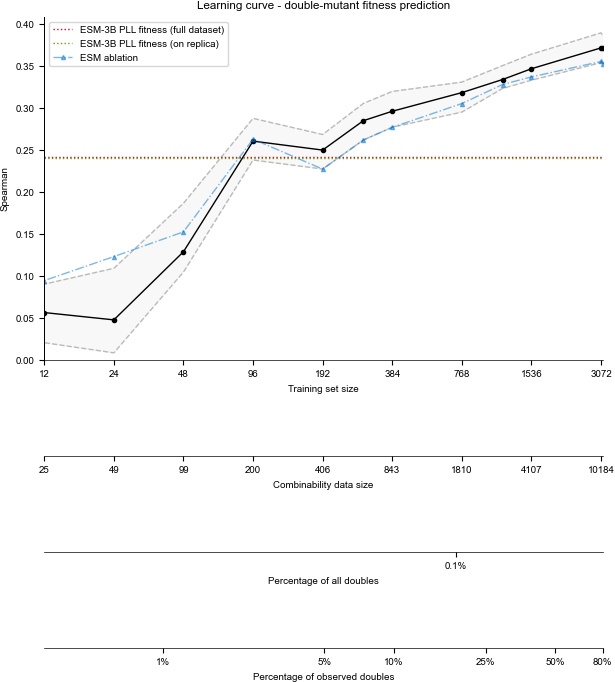

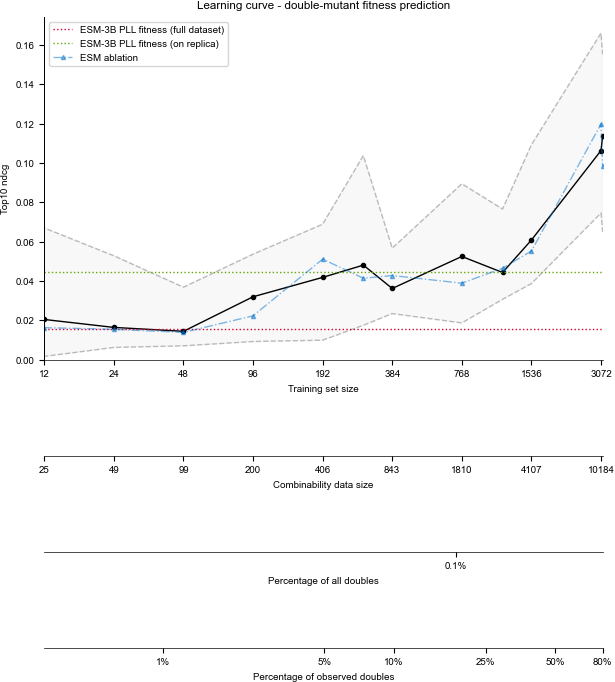

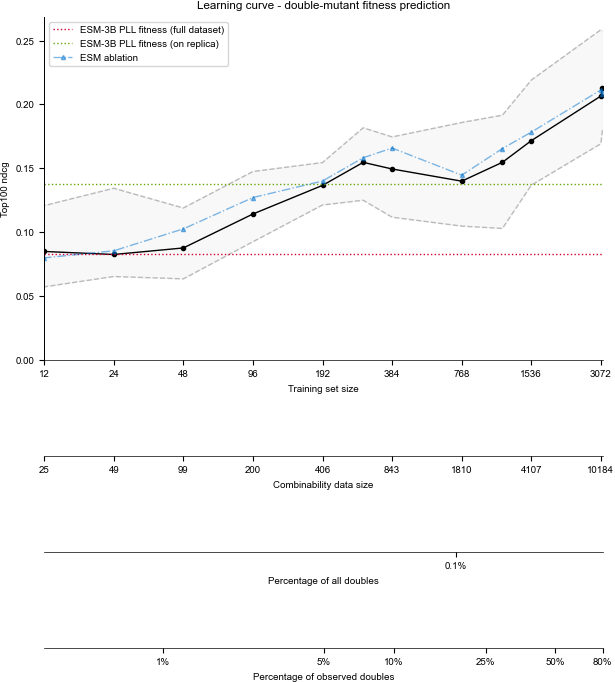

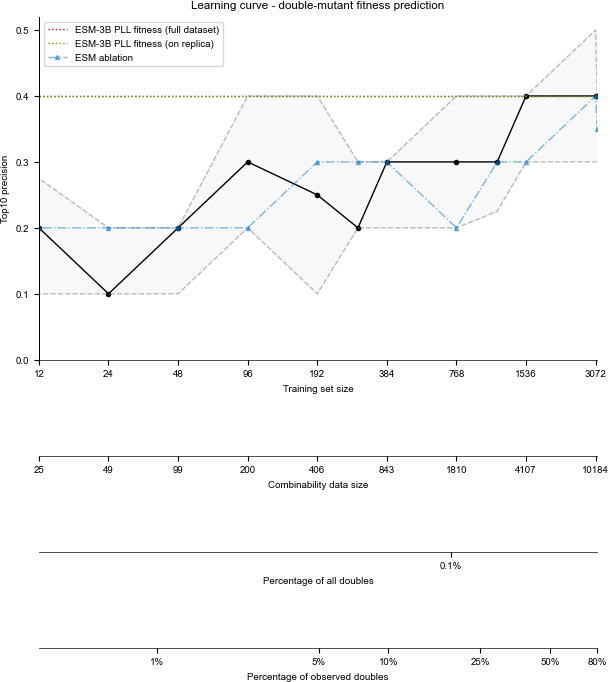

In [24]:
percentages = [0.1, 1, 5, 10, 25, 50, 80]

for metric in ["spearman", "top10_ndcg", "top100_ndcg", "top10_precision"]:
    # Extract the data for plotting
    keys = []
    combs = {}
    medians, q25s, q75s = [], [], []
    for key, value in output["result_stats"].items():
        keys.append(int(key))
        medians.append(value[metric]["med"])
        q25s.append(value[metric]["q25"])
        q75s.append(value[metric]["q75"])
        combs[int(key)] = output["cv0"][key]["combinability_size"]
    keys = np.array(keys)
    medians = np.array(medians)
    q25s = np.array(q25s)
    q75s = np.array(q75s)

    keys_esm_ablation = []
    medians_esm_ablation, q25s_esm_ablation, q75s_esm_ablation = [], [], []
    for key, value in esm_ablation["result_stats"].items():
        keys_esm_ablation.append(int(key))
        medians_esm_ablation.append(value[metric]["med"])
        q25s_esm_ablation.append(value[metric]["q25"])
        q75s_esm_ablation.append(value[metric]["q75"])
    keys_esm_ablation = np.array(keys_esm_ablation)
    medians_esm_ablation = np.array(medians_esm_ablation)
    q25s_esm_ablation = np.array(q25s_esm_ablation)
    q75s_esm_ablation = np.array(q75s_esm_ablation)

    keys_comb_ablation = []
    medians_comb_ablation, q25s_comb_ablation, q75s_comb_ablation = [], [], []
    for key, value in comb_ablation["result_stats"].items():
        keys_comb_ablation.append(int(key))
        medians_comb_ablation.append(value[metric]["med"])
        q25s_comb_ablation.append(value[metric]["q25"])
        q75s_comb_ablation.append(value[metric]["q75"])
    keys_comb_ablation = np.array(keys_comb_ablation)
    medians_comb_ablation = np.array(medians_comb_ablation)
    q25s_comb_ablation = np.array(q25s_comb_ablation)
    q75s_comb_ablation = np.array(q75s_comb_ablation)

    # 1 column figure
    with plt.style.context(["nature"]):
        for _i, width in enumerate([WIDTH.nature_2column]):
            _i += 1
            fig, ax = plt.subplots(figsize=get_dim(width=width))

            # Special case for ESM
            ax.plot(keys, medians, "ko-")
            # ax.errorbar(keys, medians, yerr=[medians-q25s, q75s-medians], fmt="none", ecolor="k")
            ax.semilogx()
            ax.fill_between(keys, q25s, q75s, alpha=0.05, color="gray")
            ax.plot(keys, q25s, color="gray", alpha=0.5, linestyle="--")
            ax.plot(keys, q75s, color="gray", alpha=0.5, linestyle="--")
            ax.set_xlabel("Training set size")
            # Remove old ticks
            ax.set_xticks([], minor=True)
            # Set new ticks
            ax.set_xticks(WELL_PLATE_SIZES_TICKS, minor=False)
            ax.set_xticklabels(WELL_PLATE_SIZES_TICKS, rotation=-00)
            ax.set_ylabel(metric.capitalize().replace("_", " "))
            ax.set_ylim(0, None)
            ax.set_xlim(WELL_PLATE_SIZES_TICKS[0], keys[-1] + 1)

            # Add ESM zero-shot performance on entire dataset
            ax.axhline(
                ESM_ZERO_SHOT[metric],
                color=cambridge_core[0],
                linestyle="dotted",
                alpha=1,
                label="ESM-3B PLL fitness (full dataset)",
            )
            ax.axhline(
                esm_performances["result_stats"][str(WELL_PLATE_SIZES[0])][metric]["med"],
                color=cambridge_core[3],
                linestyle="dotted",
                label="ESM-3B PLL fitness (on replica)",
            )

            # Add LR only
            ax.plot(
                keys_esm_ablation,
                medians_esm_ablation,
                color=cambridge_core[1],
                linestyle="dashdot",
                marker="^",
                alpha=0.5,
                label="ESM ablation",
            )
            # ax.plot(keys_comb_ablation, medians_comb_ablation, color=cambridge_core[2], linestyle="dashdot", marker="^", alpha=0.5, label="Combinability ablation")
            plt.legend(loc="best")

            # Get an intermediate axis for the combinability data
            ax1 = ax.twiny()
            ax1.semilogx()
            ax1.set_xticks([], minor=True)
            ax1.set_xticks(WELL_PLATE_SIZES_TICKS, minor=False)
            ax1.set_xticklabels([f"{combs[k]}" for k in WELL_PLATE_SIZES_TICKS], rotation=-00)
            ax1.set_xlabel("Combinability data size")

            # Adjust position of secondary x-axis
            ax1.xaxis.set_ticks_position("bottom")
            ax1.xaxis.set_label_position("bottom")
            ax1.spines["bottom"].set_position(("axes", -0.28 / _i))
            ax1.set_xlim(ax.get_xlim())

            # Make sure the axis is visible
            ax1.axis("on")

            # Show percentage of all singles on secondary x-axis
            # Calculate the positions for the secondary axis ticks (10%, 25%, 50% of the primary axis range)
            secondary_ticks = np.array(percentages) * len(doubles) / 100.0

            # Duplicate x-axis for % of dataset
            ax2 = ax.twiny()
            ax2.semilogx()
            # Remove old ticks
            ax2.set_xticks([], minor=True)
            ax2.set_xticks(secondary_ticks, minor=False)
            ax2.set_xticklabels([f"{p}%" for p in percentages])
            ax2.set_xlabel("Percentage of all doubles")

            # Adjust position of secondary x-axis
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            ax2.spines["bottom"].set_position(("axes", -0.56 / _i))
            ax2.set_xlim(ax.get_xlim())

            # Show percentage of all observed data on tertiary x-axis
            # Calculate the positions for the secondary axis ticks (10%, 25%, 50% of the primary axis range)

            secondary_ticks = np.array(percentages) * len(doubles.data.query("observed")) / 100.0
            ax3 = ax.twiny()
            ax3.semilogx()
            # Remove old ticks
            ax3.set_xticks([], minor=True)
            ax3.set_xticks(secondary_ticks, minor=False)
            ax3.set_xticklabels([f"{p}%" for p in percentages])
            ax3.set_xlabel("Percentage of observed doubles")

            # Adjust position of secondary x-axis
            ax3.xaxis.set_ticks_position("bottom")
            ax3.xaxis.set_label_position("bottom")
            ax3.spines["bottom"].set_position(("axes", -0.84 / _i))
            ax3.set_xlim(ax.get_xlim())

            # Hide the original x-axis label
            # ax.xaxis.label.set_visible(False)

            sns.despine()
            plt.title("Learning curve - double-mutant fitness prediction")

        if SAVE:
            # plt.tight_layout()
            save_timestamped_figure(
                f"learning_curve_doubles_{metric}_xgb_{_i}col",
                SAVE_DIR,
                bbox_inches="tight",
                file_types=["pdf"],
                date_format="",
            )
        plt.show()